# Getting started with packages imports and git repo cloning

In [ ]:
!git clone -b phi https://github.com/PhiCtl/isospec-internship/

In [ ]:
!pip install "glycowork[ml]" nbdev glycowork

In [3]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
from nbdev.showdoc import show_doc

import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from glycowork.ml.models import *
from glycowork.ml.inference import *
from glycowork.ml.processing import *
from glycowork.ml.model_training import *
from glycowork.ml.train_test_split import *
from glycowork.glycan_data.loader import df_species, df_glycan, glycan_binding
from glycowork.glycan_data.loader import *

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

In [102]:
import sys
sys.path.insert(0,'/content/isospec-internship/notebooks')

from embed_helpers import *

In [6]:
DATA_PATH = "/content/isospec-internship/data/glycan_embedding"

# Datasets

In [7]:
# Extracted glycans used for inference and enrichment
df_glycan_list = pd.read_csv(os.path.join(DATA_PATH, 'glycan_list.csv')).rename(columns={'tissue_species': 'Species'})
df_glycan_list['type'] = 'unknown'
df_glycan_list.head()

,glycan,Composition,Species,tissue_sample,type
0,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,"{'dHex': 2, 'HexNAc': 4, 'Hex': 3}",['Homo_sapiens'],['blood'],unknown
1,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4, 'dHex': 1}",['Homo_sapiens'],['blood'],unknown
2,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",['Homo_sapiens'],['blood'],unknown
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4}",['Homo_sapiens'],['blood'],unknown
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,"{'dHex': 1, 'HexNAc': 5, 'Hex': 5}",['Homo_sapiens'],['blood'],unknown


In [8]:
# Curated list for inference
df_glycan = df_glycan[~df_glycan['glycan'].isin(df_glycan_list['glycan'].to_list())] # Remove glycans of interest from the curated list...
df_glycan.shape

(50589, 23)

In [9]:
print(f"There are {df_glycan.explode('Species')['Species'].nunique()} unique species in the data set",
         f"and {df_glycan.explode('disease_association')['disease_association'].dropna().nunique()-1} diseases.")

There are 2793 unique species in the data set and 59 diseases.


In [10]:
print(f"There are {glycan_binding.shape[0]} different proteins and {glycan_binding.shape[1]} associated binding glycans.")
glycan_binding.head()

There are 1465 different proteins and 2745 associated binding glycans.


,3-Anhydro-Gal(a1-3)Gal(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal2S(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3dGal(b1-3)[Fuc(a1-4)]Glc,3dGal(b1-4)Glc,4d8dNeu5Ac(a2-3)Gal(b1-4)Glc,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,...,wwwSflexneri5c,wwwSflexneriO2c,wwwSflexneriO5c,wwwSisomicin,wwwSmix,wwwTobramycin,wwwTyrS,wwwpHGGs,target,protein
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AADSIPSISPTGIITPTPTQSGMVSNCNKFYDVHSNDGCSAIASSQ...,TAL6-4LysM
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAFFSLVVLLALLPFGIHASALPSTELTPRVNPNLPGPNDVFVGFR...,rCnSL-proA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AANEADYQAKLTAYQTELARVQKANADAKAAYEAAVAANNAANAAL...,AntigenI/IIA3VP1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AASKLGVPQPAQRDQVNCQLYAVQPNDNCIDISSKNNITYAQLLSW...,TAL6-6LysM
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACNNEWEDEQYEQYISFKSPIPAGGEGVTDIYVRYKEDGKVTYRLP...,SP15308A-bot-339-19-339


In [11]:
# Used to control representation in the embedding space by assessing closeness
df_N_glycans = pd.read_csv(os.path.join(DATA_PATH, 'N_glycans_df.csv'))
df_N_glycans['type'] = 'N_glycans'

# N glycans are present within df_glycan df
res = pd.merge(df_N_glycans, df_glycan, on='glycan', how='left', indicator =True)
res = res[res['_merge'] == 'left_only'].drop('_merge', axis=1)
print(res)

Empty DataFrame
Columns: [glycan, Species_x, Genus_x, Family_x, Order_x, Class_x, Phylum_x, Kingdom_x, Domain_x, ref_x, glytoucan_id_x, glycan_type_x, disease_association_x, disease_id_x, disease_sample_x, disease_direction_x, disease_ref_x, disease_species_x, tissue_sample_x, tissue_id_x, tissue_ref_x, tissue_species_x, Composition_x, Structure_Type, type, Species_y, Genus_y, Family_y, Order_y, Class_y, Phylum_y, Kingdom_y, Domain_y, ref_y, glytoucan_id_y, glycan_type_y, disease_association_y, disease_id_y, disease_sample_y, disease_direction_y, disease_ref_y, disease_species_y, tissue_sample_y, tissue_id_y, tissue_ref_y, tissue_species_y, Composition_y]
Index: []

[0 rows x 47 columns]


# 1 - Approaches reflexion

Getting inspiration from [Using graph convolutional neural networks to learn a representation for glycans](https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1) :
* Sweetnet is a graph convolutional network (GCNN) that provides a useful glycan representation using glycan sequences.
* Sweetnet was trained using _the task of predicting which species a given glycan sequence came from_, ie. a multiclass classification task for a better model performance comparison. The GCNN approach outperformed existing approaches on the classification task. See more about Sweetnet training [here](https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb).
* Since solving this task was successful, the authors infered that the hidden glycan representation learned by the network was meaningful, and demonstrated it on various downstream tasks.

The state of the art embedding for glycans from different species is already computed by Sweetnet graph. Using graph neural networks seems the best possible approach. Nevertheless, different approaches for embedding can be used:
* Take advantage of curated Sweetnet GCNN architecture for glycan sequence embedding, train the model on all glycans sequences with the task of predicting the species. ``` composition ``` and ```tissue_sample``` features could be leveraged for embedding space learning as well, but 1) ```composition``` is redundant with the glycan sequence and 2) ```tissue_sample``` might not exactly reflect glycan presence in tissues.
* Same task as above predicting the glycan type (eg. N, O, etc...).
* Explore another type of graph neural network architecture, namely graph transformers ([See HugginFace website](https://huggingface.co/docs/transformers/en/model_doc/graphormer#usage-tips)).



# 2- Using Sweetnet trained on a classification task

* Species classification : Multi class classification, ie. each glycan can belong to several species.

## 2.1 Data processing for species classification

In [117]:
df_data = df_glycan.explode('Species')
df_data = df_data.drop_duplicates(['Species', 'glycan'])

In [118]:
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_data,
                                                                              rank = 'Species', min_seq=10)

## 2.1 Data processing for glycan type classification

In [50]:
df_data = df_glycan[df_glycan['glycan_type'].isin(['free', 'lipid', 'N', 'O', 'repeat'])]
class_list = df_data['glycan_type'].unique().tolist()
class_converter = {class_list[i] : i for i in range(len(class_list))}
train_x, val_x, train_y, val_y = general_split(df_data['glycan'].values.tolist(),\
                                               df_data['glycan_type'].map(class_converter).values.tolist(), test_size=0.2)

In [61]:
print(f"{len(train_x)} glycans and {len(class_list)} classes")

21560 glycans and 5 classes


## 2.2 Model training

### 2.2.1 Actually training the model

Model training for species classification achieved similar accuracy on the validation set than reported on the paper, ie. 0.44.

In [ ]:
dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)
model = prep_model('SweetNet', trained=False, num_classes=len(class_list))
optimizer_ft, scheduler, criterion = training_setup(model, 0.0005, num_classes = len(class_list))
model_ft_3 = train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100)

In [53]:
#torch.save(model_ft_3, '/content/SweetNet_glycan_type.pt')
torch.save(model_ft_3, '/content/SweetNet_species_10.pt')

### 2.2.2 Retrieving trained model weights

In [116]:
# Change device if on GPU
model_ft_3 = torch.load('/content/isospec-internship/models/SweetNet_species_10.pt')
model_ft_3.eval()

SweetNet(
  (conv1): GraphConv(128, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (item_embedding): Embedding(2566, 128)
  (lin1): Linear(in_features=128, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=556, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (act2): LeakyReLU(negative_slope=0.01)
)

## 2.3 Embedding visualisation

Glycan type : for the sake of visualisation, distinguish glycans used for embedding training from N-glycans and "discovered glycans".

In [136]:
cols = ['glycan', 'Species', 'Kingdom', 'glycan_type', 'disease_association', 'disease_species', 'tissue_sample', 'tissue_species', 'Composition']
glycans = df_data.merge(df_N_glycans[['glycan', 'type']], on='glycan', how='outer')\
                    .fillna({'type' : 'known'})\
                    [cols]

if not isinstance(glycans['Species'], list):
  glycans = glycans.groupby('glycan').agg({'Species':lambda ss : list(ss),
                                         'Kingdom' : lambda x : x,
                                         'glycan_type': lambda x : x,
                                         'disease_association': lambda x : x,
                                         'disease_species': lambda x : x,
                                         'tissue_sample': lambda x : x,
                                         'tissue_species': lambda x : x,
                                         'Composition': lambda x : x}).reset_index()

add_cols = glycans.columns.difference(df_glycan_list.columns)
for c in add_cols:
  df_glycan_list[c] = None
glycans = pd.concat([glycans, df_glycan_list]).reset_index(drop=True)
glycans['from_human'] = glycans['Species'].apply(lambda ss : 'Human glycan' if 'Homo_sapiens' in ss\
                                                 else 'Non human glycan')
df_learned_rep = glycans_to_emb(glycans['glycan'].values, model_ft_3)

In [137]:
# Get glycan main metadata
df_learned_rep_augm = df_learned_rep.merge(glycans, left_index=True, right_index=True)

### 2.3.1 Cluster visualisation

In [75]:
tsne_emb_1 = TSNE(random_state = 42).fit_transform(df_learned_rep_augm.drop([c for c in glycans.columns], axis=1))

In [76]:
tsne_emb_1 = pd.DataFrame(tsne_emb_1).merge(df_learned_rep_augm[[c for c in glycans.columns]], left_index=True, right_index=True)
tsne_emb_1.set_index('glycan', inplace=True)

In [ ]:
plot_embedding_classes(tsne_emb_1, 't-SNE', visualization_hue='glycan_type', save_fig=True)

* Species classification
  * We can see from the cluster plot that N-linked glycans seem to cluster on the top right part of the graph, mostly on human glycan clusters. Our unknown glycans seem to belong to human glycans clusters, as expected from their tissue sample origin. Two of the unknown glycans with very similar sequence cluster very closely.
* glycan type classification : embeddings of the same glycan type cluster tightly on t-SNE plot. Our glycans of interest seem to belong to the N-glycan cluster.

PCA 1D clustering visualisation was not informative.

## 2.4 Enrich glycan information

The task is to find the most similar glycans to the unknown glycans of interest in the embedding space.

Several approaches can be considered:
* Finding the most relevant neighbours based on a suitable distance metric in the embedding space.
  * The most simple approach is to define a cosine distance threshold and keep all the datapoints below that threshold.
  * The second approach would be to find an inflection point in the distance curve and to define all the neighbours before that point as belonging to the cluster of interest. We will keep this second approach.
  * This stage would need validation with other methods to see whether we end up with semantically consistent clusters around the points of interest.
* Clustering the data.

I carefully chose the cosine distance or the Manhattan distance metrics as Euclidean distance metrics is not suited for high dimensions.


### 2.4.1 Finding relevant neighbours

In [140]:
# Retrieve high dimensional embeddings without metadata
df_reps = df_learned_rep_augm.set_index('glycan')\
          [[i for i in range(128)]]\
          .T

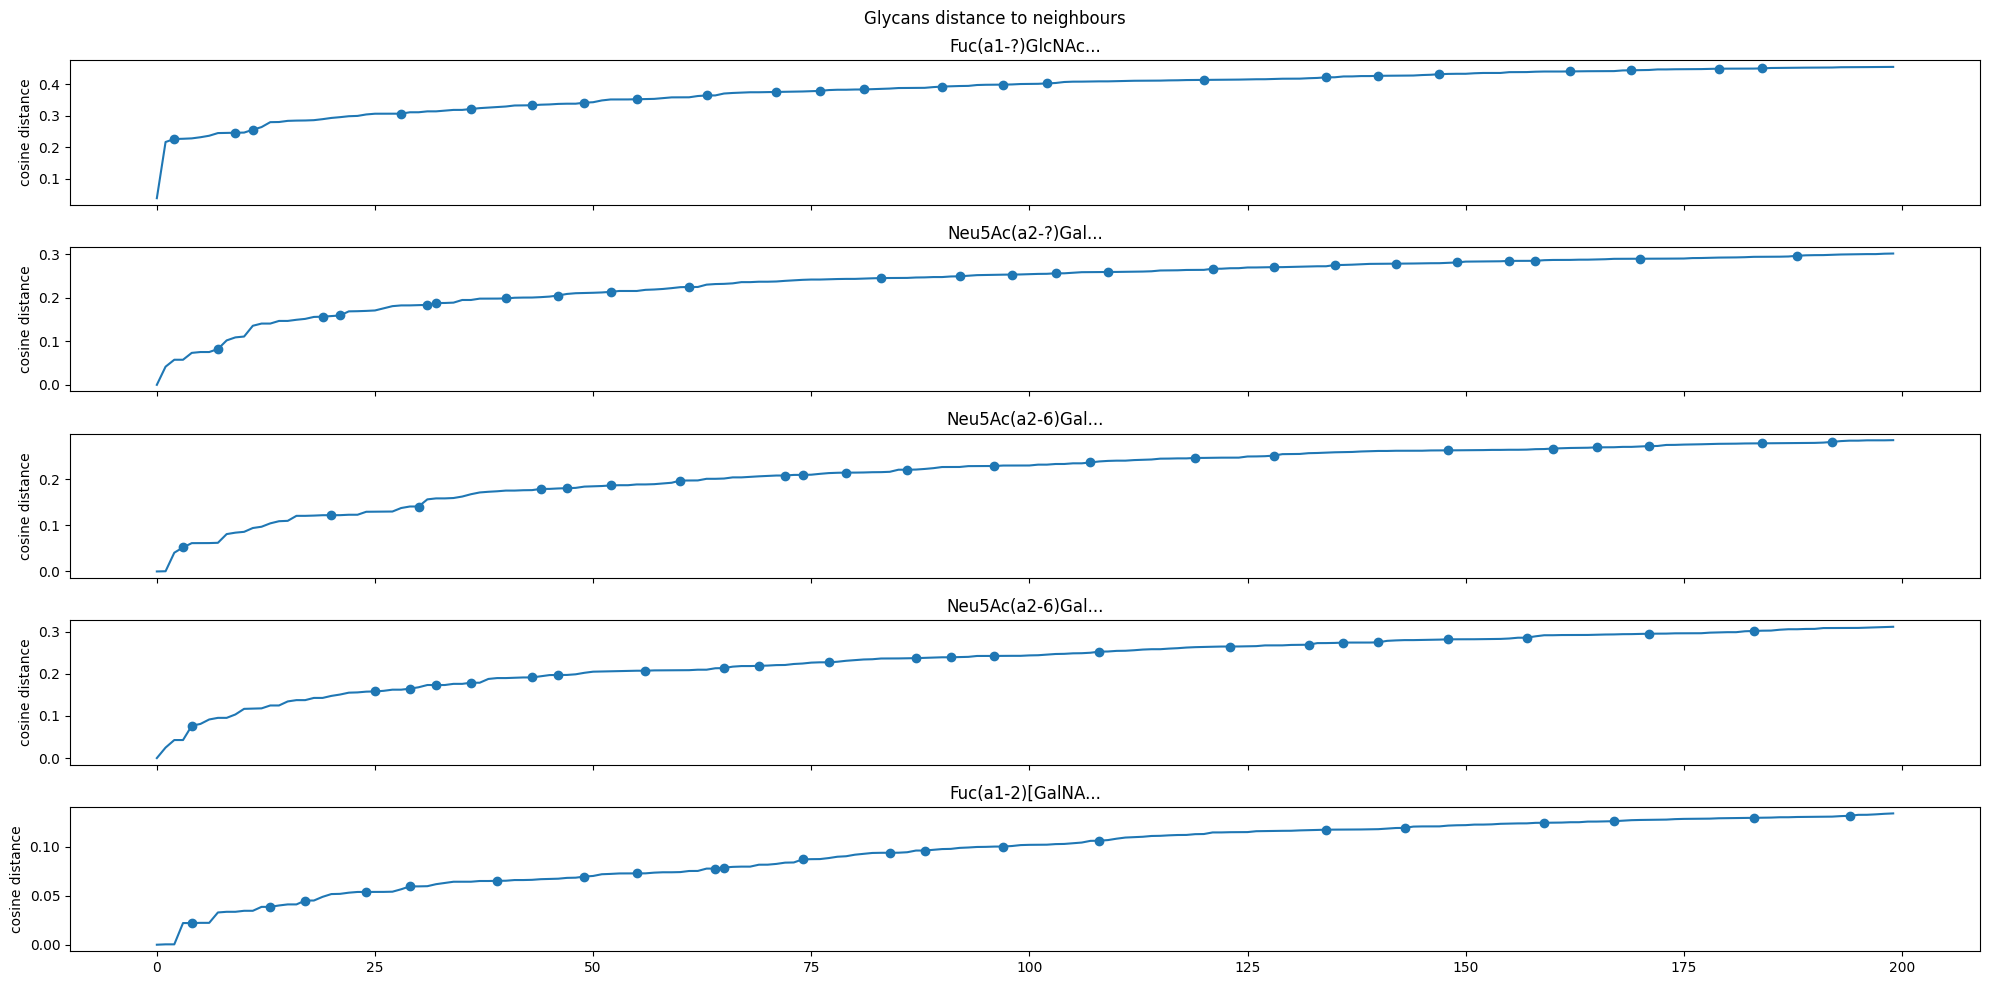

In [141]:
closest_ngb_cosine = plot_neighbours_distance(df_reps, df_glycan_list, max_dist=200, save_fig=True, smoothing_sigma=3)

In [ ]:
closest_ngb_manh= plot_neighbours_distance(df_reps, df_glycan_list, metric='cityblock', save_fig=True, max_dist=200, smoothing_sigma=3)

### 2.4.2 Find clusters

https://www.datacamp.com/tutorial/dbscan-clustering-algorithm

#### TODO
- [ ] Based on meaningful distance, choose carefully epsilon and the minimum number of neighbours.

In [80]:
# All glycan data embeddings
X = df_reps.T

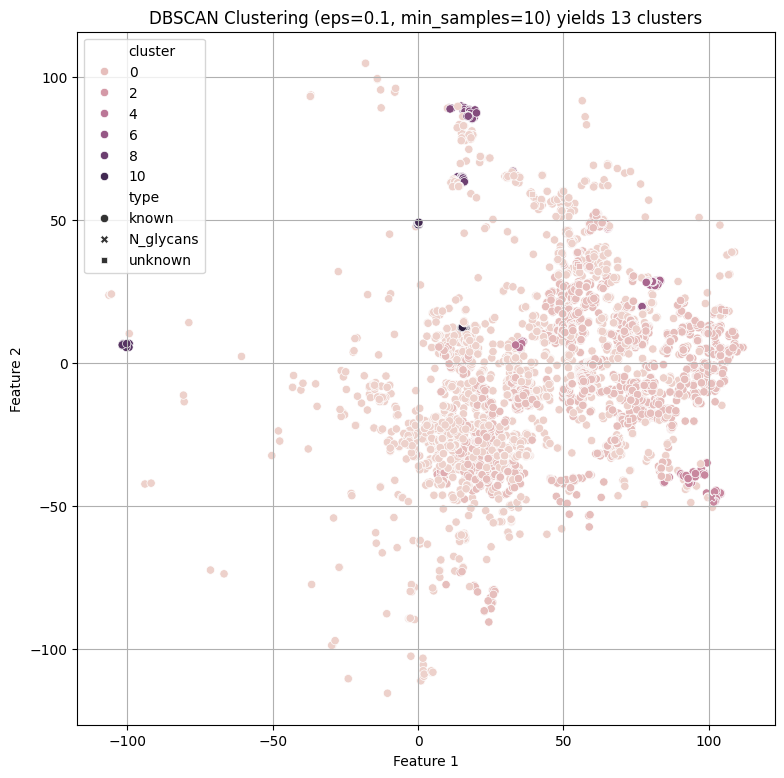

In [85]:
run_dbscan(X, tsne_emb_1[tsne_emb_1['from_human'] == 'Human glycan'], eps=0.1, min_samples=10)

### 2.4.3 Analyse neighbours

Print and save enriched list of discovered glycans :

In [146]:
metadata = ['Species', 'glycan_type',\
                      'disease_association', 'tissue_sample',\
                      'disease_species']

def glycan_information(glycan, neighbours, df_metadata, metadata, df_proteins_binding, closeness_level=1, print_agg=False):
    """
    Analyzes and prints information about a given glycan and its neighbours, including metadata and protein binding data.
    Parameters:
    glycan (str): The glycan of interest.
    neighbours (dict): A dictionary where keys are glycans and values are lists of neighbouring glycans.
    df_metadata (pd.DataFrame): DataFrame containing metadata about glycans.
    metadata (list): List of metadata columns to be considered.
    df_proteins_binding (pd.DataFrame): DataFrame containing protein binding data for glycans.
    closeness_level (int, optional): The level of closeness to consider for neighbours. Defaults to 1.
    print_agg (bool, optional): If True, prints aggregated metadata for each neighbour. Defaults to False.
    Returns:
    pd.DataFrame: DataFrame containing metadata and protein binding information for the glycan and its neighbours.
    """

    assert(isinstance(glycan, str))
    assert(isinstance(neighbours, dict) & (glycan in neighbours.keys()))
    assert(isinstance(df_metadata, pd.DataFrame))
    assert(isinstance(metadata, list))
    assert(isinstance(df_proteins_binding, pd.DataFrame))

    neighbours_metadata = pd.DataFrame({'neighbours' : [i for j in neighbours[glycan] for i in j],\
                                        'infl_order':[1]*len(neighbours[glycan][0]) +
                                                        [2]*len(neighbours[glycan][1]) +
                                                        [3]*len(neighbours[glycan][2])})
    neighbours_metadata = neighbours_metadata.merge(df_metadata[metadata + ['glycan']].drop_duplicates('glycan'),\
                                                    left_on='neighbours', right_on='glycan', how='left')\
                                            .query('infl_order <= @closeness_level')\
                                            .drop('glycan', axis=1).drop_duplicates('neighbours')

    print(f"For glycan {glycan} and its {neighbours_metadata['neighbours'].nunique()} neighbours:\n", "\n")
    if print_agg:
        for c in metadata:
            print("###", c, "\n")
            for _, g in neighbours_metadata.iterrows():
                print(g['neighbours'], ": ")
                print(g[c], "\n")
            print("*"*len(g['neighbours']), "\n")

    else :
        for c in metadata:
            d = neighbours_metadata[[c]].dropna()
            print(d.explode(c).value_counts(), "\n")

    # Find neighbouring glycans for which we have protein binding data
    glycans_binding = list(set(neighbours_metadata['neighbours'].drop_duplicates()).intersection(set(df_proteins_binding.columns)))
    proteins = set()
    bindings = {g : [] for g in glycans_binding}
    for g in glycans_binding:
        p = list(df_proteins_binding[~df_proteins_binding[g].isna()].set_index('protein').index)
        proteins.update(p)
        bindings[g] = p
    print(f"{len(proteins)} known interacting proteins among catalogued glycans are common to all neighbours.")

    # Return metadata
    df_bindings = pd.DataFrame({'neighbours':[g for g in bindings.keys()], 'proteins': [bindings[g] for g in bindings.keys()]})
    neighbours_metadata = neighbours_metadata.merge(df_bindings, on='neighbours', how='outer')

    return neighbours_metadata





In [148]:
df_info = glycan_information(df_glycan_list['glycan'].values[1],
                       closest_ngb_cosine,
                       glycans, metadata,
                       glycan_binding,
                       closeness_level=2, print_agg=True)

For glycan Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc and its 20 neighbours:
 

### Species 

GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc : 
[nan] 

Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc : 
['Homo_sapiens', 'HumanImmunoDeficiency_Virus'] 

Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc : 
['Homo_sapiens'] 

Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc : 
['Homo_sapiens'] 

Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc : 
['Bos_grunniens', 'Bos_taurus'] 

Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc : 
[nan] 

Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b

_For protein binding metadata, run the code._
Looking at all the neighbours before the second inflection point detected, for glycan type classification vs species classification, we gain the following information below:

### Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc

* 4 / 13 neighbours : Homo sapiens vs 4 / 10 Homo sapiens neighbours
* all neighbours are N-glycans in both classification tasks.
* Associated disease : female breast cancer (1 neighbour). No associated disease for species classification resulting embedding.

### Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc

* 11 / 22 neighbours are found in Homo Sapiens. vs 12 / 20.
* All neighbours are N-glycans.
* This glycan is associated with type_2_diabetes_mellitus (2 neighbours), oesophageal cancer (1 neighbour), and colorectal cancer (3 neighbours).
* type_2_diabetes_mellitus (3), benign_breast_tumor_tissues_vs_para_carcinoma_tissues (2),

### Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc
* 23 / 39 neighbours are found in Homo Sapiens.
* All neighbours are N glycans as well.
* Toxoplasma_gondii_infection (2 neighbours), esophageal_cancer (1), lung_non_small_cell_carcinoma (2 neighbours), type_2_diabetes_mellitus(1)

### Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc

* 13 / 25 : Homo sapiens
* N glycan
* colorectal_cancer (4), type_2_diabetes_mellitus (1), esophageal_cancer (1)

### Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc
* 6 / 10 Homo sapiens
* N glycan
* no disease association



